---
title: transform()ing Like a Pro in Pandas
toc: true
---

# 1. Introduction

XXX Motivation

XXX Summary

We import Pandas for DataFrame creation, `random` for generation of random data in our DataFrame, and `datetime.datetime` and `datetime.timedelta` for purchase date creation. We furthermore import Matplotlib to inspect the data.

In [1]:
import pandas as pd
import random
from datetime import datetime, timedelta

import matplotlib.pyplot as plt

Just while creating this notebook I was struggling with one thing in particular while playing around with DataFrame creation. DataFrames printed inside IPython are sometimes just too long and have too many rows. Just typing `df` and having a perfectly formatted HTML table of the head and tail of the DataFrame you want to inspect come out is just too convenient.

So naturally, I wondered whether there was any way to shorten the number of rows printed when evaluating a DataFrame. `pandas.set_option` to the rescue. The [documentation](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.set_option.html) has a full list of all options available, and one option that we find interesting in particular is `max_rows`. It determines the maximum amount of rows pandas will output when outputting truncated DataFrames. A dataframe is truncated depending on how much space is available for printing it. In the case of the terminal, this is pretty easy to find out. Pandas just needs to see what the terminal's character dimensions are. In the case of IPython and Jupyter, this is not so easy. There is no API available for determining the browser window dimensions inside Pandas. So we're stuck with manually setting a value.

We choose 6 as the maximum number of rows, including the head _and_ tail of a DataFrame.

In [2]:
pd.set_option('display.max_rows', 6)

Today's DataFrame, readily filled with fake data, consists of the following data.

Since we want to keep it entertaining, the data we look at today is e-commerce purchase data. We look at a table containing purchase items, and data that is associated with them. The purchase items are linked to a specific order ID. One purchase can have several purchase items. To sum it up, we create the following columns.

- `date`: Date of purchase
- `category`: Category of item, either __Food__, __Beverage__ or __Magazine__
- `value`: Purchase value of item, ranges from 10 to 100
- `customer`: ID of customer that purchased this item, a random ID from 1 to 10
- `purchase`: ID of purchase, there are 30 purchases with IDs ranging from 1 to 30

In [3]:
random.seed(1)
category_names = [
    "Food",
    "Beverage",
    "Magazine",
]
start_date = datetime(2017, 1, 1)
rows = 100
df = pd.DataFrame(
    [
        [
            start_date + timedelta(
                days=random.randint(0, 30)
            ),
            random.choice(category_names),
            random.randint(10, 100),
            random.randint(1, 10),
            random.randint(1, 30),
        ]
        for _ in range(rows)
    ],
    columns=[
        "date",
        "category",
        "value",
        "customer",
        "purchase",
    ],
)
df.index.name = "item_id"
df

,date,category,value,customer,purchase
item_id,,,,,
0,2017-01-05,Magazine,18,5,4
1,2017-01-16,Beverage,70,7,26
2,2017-01-07,Food,72,1,29
...,...,...,...,...,...
97,2017-01-30,Beverage,41,6,4
98,2017-01-18,Magazine,84,10,3
99,2017-01-08,Food,12,4,13


That should give us some useful purchase data to work with.

# 2. The Problem

The other day I was working on an interesting problem that I could only solve in a cumbersome way with Pandas before. For each purchase in a similar DataFrame, I wanted to calculate a purchase item's overall contribution to the total purchase value. So for example, if a customer bought two \$10 items for a total value of $20, one purchase item would contribute 50% to the total purchase value.

In order to find the total purchase value, we would typically use a group by together with a `.sum()`. Since we need to calculate the ratio of a purchase item's value to the total purchase value, we would need to join that data back to the original DataFrame. Or at least, this is how I would have done it before finding out about `.transform()`.

Let's take it step by step and look at the necessary calculation steps. First, we need to group by a purchase ID and sum up the total purchase value. Therefore, we need to group by `purchase` and sum up the `value` column:

In [4]:
values = df.groupby('purchase').value.sum()
values.to_frame()

,value
purchase,
2,146
3,398
4,377
...,...
28,89
29,329
30,63


What we get is a Pandas Series containing the total purchase values for every purchase ID. Since we used a group by on the purchase ID, `purchase` is the index of this Series. We can visualize this data with a bar plot.

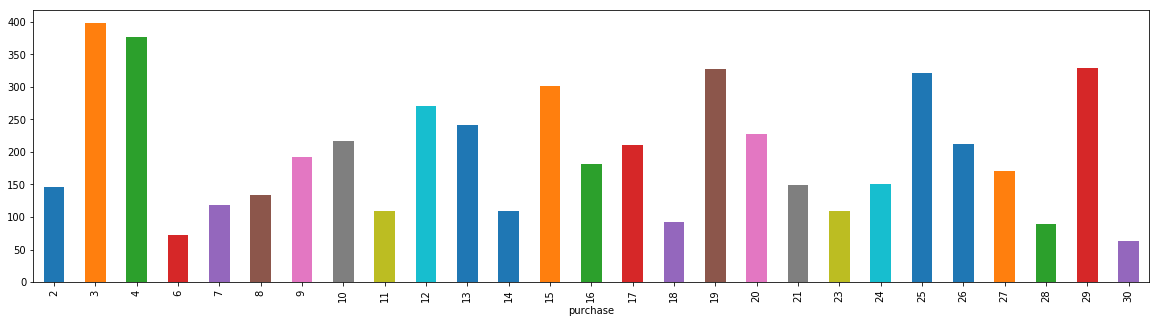

In [5]:
fig, ax = plt.subplots(1, figsize=(20, 5))
values.plot(kind='bar', ax=ax)
fig

Now that we have the total purchase value for each purchase ID, we can join this data back to the purchase DataFrame. For this, we perform a left join of the purchase values to the DataFrame on `purchase`. We further specify that the value of the right side should receive the suffix `_total`. If we take a look again at our total purchase values, we can see that the name of the Series is the following.

In [6]:
values.name

'value'

So if we join without specifying a suffix, Pandas will complain about a name collision. This is because both sides specify a column named `value`, which can obviously not be joined, since it is unclear which column should take precedence. Therefore, we need to have the right side column in the Series that we are joining change its name by using the suffix `_total`. Indicating that it is a total value in the name of course makes a lot of sense, since the column contains the total purchase values.

Let's perform the actual join then 🚀

In [7]:
df.join(values, on='purchase', rsuffix='_total')

,date,category,value,customer,purchase,value_total
item_id,,,,,,
0,2017-01-05,Magazine,18,5,4,377
1,2017-01-16,Beverage,70,7,26,213
2,2017-01-07,Food,72,1,29,329
...,...,...,...,...,...,...
97,2017-01-30,Beverage,41,6,4,377
98,2017-01-18,Magazine,84,10,3,398
99,2017-01-08,Food,12,4,13,241


As we have discussed before, we want to calculate the ratio of a single purchase item to the total purchase value. We therefore need to calculate `value / value_total * 100` to retrieve the ratio as a percentage.

In [8]:
df.assign(
    value_pct=(
        df.value /
        df.join(
            values,
            on='purchase',
            rsuffix='_total',
        ).value_total *
        100
    )
).round(2)

,date,category,value,customer,purchase,value_pct
item_id,,,,,,
0,2017-01-05,Magazine,18,5,4,4.77
1,2017-01-16,Beverage,70,7,26,32.86
2,2017-01-07,Food,72,1,29,21.88
...,...,...,...,...,...,...
97,2017-01-30,Beverage,41,6,4,10.88
98,2017-01-18,Magazine,84,10,3,21.11
99,2017-01-08,Food,12,4,13,4.98


To be honest, for a long time I thought that this was the only way to do it. At the same time I was more than concerned with how burdensome it is to join the values back to the original DataFrame.

Browsing through the Pandas documentation let me discover an extremely useful method, the `.transform()`. Time after time, aimlessly wandering through documentation has brought positive change into my humble life.

Using transform, we will simplify the above process and make the present an even more exciting time to be alive in.

# 3. Transform to the Rescue

While `.transform()`'s API is fairly well documented, I could only find a few hints to what the use cases might be [in the documentation](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.transform.html#pandas.DataFrame.transform).

Now I would like to present the perfect use case for `.transform()`. First, let's take a look at what the method exactly returns. We will define a method that prints the value it receives and returns the same value.

In [9]:
def return_print(value):
    print(value)
    return value

We then use `.transform()` to apply this function on our DataFrame. To avoid the result from getting too long we only apply it to the category and value column. We will immediately see that the category column is evaluated twice, which seems strange. Read on to find out why.

In [10]:
df[['category', 'value']].transform(return_print)

item_id
0     Magazine
1     Beverage
2         Food
        ...   
97    Beverage
98    Magazine
99        Food
Name: category, Length: 100, dtype: object
item_id
0     Magazine
1     Beverage
2         Food
        ...   
97    Beverage
98    Magazine
99        Food
Name: category, Length: 100, dtype: object
item_id
0     18
1     70
2     72
      ..
97    41
98    84
99    12
Name: value, Length: 100, dtype: int64


,category,value
item_id,,
0,Magazine,18
1,Beverage,70
2,Food,72
...,...,...
97,Beverage,41
98,Magazine,84
99,Food,12


It is interesting to see that Pandas executes `return_print` on the first column twice. Therefore, we also see it being printed twice. This is done for reasons of optimization: Pandas needs to find out which code path it can execute, as there is a fast and slow way of transforming ndarrays. Therefore, the first column is evaluated twice. As always, [the documentation](https://pandas.pydata.org/pandas-docs/stable/groupby.html#flexible-apply) describes this mechanism quite well (look for the __Warning__ section).

We can furthermore observe that the result is a completely unchanged DataFrame. This is reassuring and lets us understand the next example even better.

We would like to calculate the [standard score](https://en.wikipedia.org/wiki/Standard_score) for each value. The standard score of a value $$x$$ is defined as

$$z=\frac{x - \mu}{\sigma}$$

where

- $$\sigma$$ is the standard deviation of all values, and
- $$\mu$$ is the mean of all values.

We can quite simple express this as a `.transform()` call, by calculating

```python
x - x.mean() / x.std()
```

where `x` denotes a column we are calculating the standard scores for. Since not every column is numerical, we limit ourselves to the `value` column and calculate standard scores for all purchase item values.

In [11]:
df.value.transform(
    lambda x: (x - x.mean()) / x.std()
).to_frame('value_standard_score')

,value_standard_score
item_id,
0,-1.354992
1,0.643862
2,0.720741
...,...
97,-0.470884
98,1.182015
99,-1.585630


An observant reader will quickly notice that we could also perform the following calculation to retrieve the same result:

In [12]:
(
    (df.value - df.value.mean()) /
    df.value.std()
).to_frame('value_standard_score_alt')

,value_standard_score_alt
item_id,
0,-1.354992
1,0.643862
2,0.720741
...,...
97,-0.470884
98,1.182015
99,-1.585630


That is absolutely correct. I can see both forms having their advantages and disadvantages. I see the advantage of using `.transform()` instead of operating on raw columns as the following:

- Define reusable methods, for example for standard score calculation, that can be applied over any DataFrame. Code reuse for the win.
- Avoid retyping the column name that you operate on. This means typing `x` versus typing `df.value` all the time.
- `.transform()` can apply several transformations at once.

Let's take a look at an example for multiple transformations applied at the same time.

In [13]:
def standard_score(series):
    """Return standard score of Series."""
    return (series - series.mean()) / series.std()

def larger_median(series):
    """Return True for values larger than median in Series."""
    return series > series.median()

df.transform({
    'value': [
        standard_score,
        larger_median,
    ],
    'date': lambda ts: ts.day
})

value                   date
        standard_score larger_median <lambda>
item_id                                      
0            -1.354992         False        5
1             0.643862          True       16
2             0.720741          True        7
...                ...           ...      ...
97           -0.470884         False       30
98            1.182015          True       18
99           -1.585630         False        8

[100 rows x 3 columns]

While we have observed in a [previous article](https://www.datakernel.co/2017/12/26/pandas-aggregates) that it is possible to assign names to function calls in `.aggregate()` to give result columns new names, it does not appear to be possible with transform.

So for example, we were able to do the following with a tuple:

```python
df.aggregate({
    'value': [
        ('mean', lambda x: x.sum() - x.count()),
    ],
})
```

We are then able to retrieve a column named 'mean' that would contain the result of the `lambda`, we cannot do the same using `.transform()` unfortunately. So this is not possible

```python
df.value.transform({
    'value': [
        ('standard_score', lambda x: (x - x.mean()) / x.std()),
    ],
})
```

We would instead just be greeted by an irritated Exception telling us to reflect on our deeds.

Leaving that aside, I would like to show you how transform becomes really useful in the next section.

# 4. The Problem, Solved

It turns out that `.transform()` can also be used in group by objects. So what would we like to do? Easy. We would like to calculate an aggregate value, similar to how it has already been possible using `.aggregate()`, and then join it back to the index of the original grouped by object. So, if we are calculating a `sum` for every group, we then add the result back to each index that corresponds to that group.

In the case of grouping by purchases and calculating a sum, we would be then adding the sum back to every purchase item. Then, we can easily look at one purchase item and know both the purchase item's value, as well as the total purchase value.

Let's try it out then, shall we?

In [14]:
ts = df.groupby('purchase').value.transform('sum')
ts.to_frame()

,value
item_id,
0,377
1,213
2,329
...,...
97,377
98,398
99,241


As we can see above, instead of directly calling `.transform()` on our well-known and beloved DataFrame, we first group by the purchase ID column. Since we have approximately 30 purchases, we will create approximately 30 groups.

Then, for each group we calculate the sum in the `.transform('sum')` call and directly join that value back to the index used before the `.groupby()` call.

We can now join that value back to our original DataFrame quite easily.

In [15]:
df.join(ts, rsuffix='_total')

,date,category,value,customer,purchase,value_total
item_id,,,,,,
0,2017-01-05,Magazine,18,5,4,377
1,2017-01-16,Beverage,70,7,26,213
2,2017-01-07,Food,72,1,29,329
...,...,...,...,...,...,...
97,2017-01-30,Beverage,41,6,4,377
98,2017-01-18,Magazine,84,10,3,398
99,2017-01-08,Food,12,4,13,241


Even more exciting, we can perform the same calculation that we have performed before, and achieve what required an additional, unpleasant `.join()` before.

In [16]:
df.assign(
    value_pct=(
        df.value /
        ts *
        100
    )
).round(2)

,date,category,value,customer,purchase,value_pct
item_id,,,,,,
0,2017-01-05,Magazine,18,5,4,4.77
1,2017-01-16,Beverage,70,7,26,32.86
2,2017-01-07,Food,72,1,29,21.88
...,...,...,...,...,...,...
97,2017-01-30,Beverage,41,6,4,10.88
98,2017-01-18,Magazine,84,10,3,21.11
99,2017-01-08,Food,12,4,13,4.98


That wasn't so bad, was it? Let's see what we can take away from today's article

In the end, we were able to avoid one unpleasant `.join()` call and have made the intent behind our summation a lot clearer. And if you want to improve the comprehensibility of your IPython notebooks, clear intent, terseness and readability are king.

# 5. Summary

With `.transform()` in our toolbox, we've acquired yet another useful tool for Data Analysis. It is always a delight to dig in the Pandas documentation to find out what other delights this great library has to offer. I hope to be able to write even more articles about obscure niches in the Pandas API and surprise you with one or two things that neither of us knew about.

So I would like to encourage you to stay tuned and go out, dig up some new Pandas DataFrame methods, and enjoy working with data.